# Zero Inflated Poisson with BART

In [1]:
import arviz as az
import bambi as bmb
import kulprit as kpt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [3]:
fish_data = pd.read_csv("fish.csv")
fish_data["adults"] = fish_data["persons"] - fish_data["child"]
fish_data

,nofish,livebait,camper,persons,child,count,adults
0,1,0,0,1,0,0,1
1,0,1,1,1,0,0,1
2,0,1,0,1,0,0,1
3,0,1,1,2,1,0,1
4,0,1,0,1,0,1,1
...,...,...,...,...,...,...,...
245,1,1,1,2,0,0,2
246,0,1,1,4,3,0,1
247,0,1,1,2,1,0,1
248,1,1,1,3,2,0,1


For the moment kulprit does not support ZIP, we will use Poisson as a placeholder

In [4]:
model = bmb.Model(
    "count ~" + " + ".join(fish_data.columns.drop(["count", "nofish", "persons"])),
    data=fish_data,
    family="poisson",
)

By default Bambi use a Gaussian likelihood with normal priors for the coeeficients in the linear term and a Half-Student t for sigma 

In [5]:
model

       Formula: count ~livebait + camper + child + adults
        Family: poisson
          Link: mu = log
  Observations: 250
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 9.0523)
            livebait ~ Normal(mu: 0.0, sigma: 7.2931)
            camper ~ Normal(mu: 0.0, sigma: 5.0793)
            child ~ Normal(mu: 0.0, sigma: 2.946)
            adults ~ Normal(mu: 0.0, sigma: 2.6013)

We fit the model. This is calling `pm.sample()` under the hood.

In [6]:
idata = model.fit(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, livebait, camper, child, adults]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Now we use Kulrprit to perform variable selection via projective prediction. In a nutshell we use the fitted model as the reference model, and we look to identify subsets of its parameters that achieve similar predictive performance.

In [7]:
ref_model = kpt.ProjectionPredictive(model, idata)
ref_model.search()

Starting from the intercept-only model up to all covariables, which variables we should include to get better and better predictions?

In [8]:
for value in ref_model.path.values():
    print(value.model.formula)

Formula(count ~ 1)
Formula(count ~ adults)
Formula(count ~ adults + camper)
Formula(count ~ adults + camper + livebait)
Formula(count ~ adults + camper + livebait + child)


We can also evaluate the submodels in terms of LOO

/home/osvaldo/proyectos/00_BM/arviz-devs/arviz/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.62 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/osvaldo/proyectos/00_BM/arviz-devs/arviz/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.62 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/osvaldo/proyectos/00_BM/arviz-devs/arviz/arviz/stats/stats.py:792:

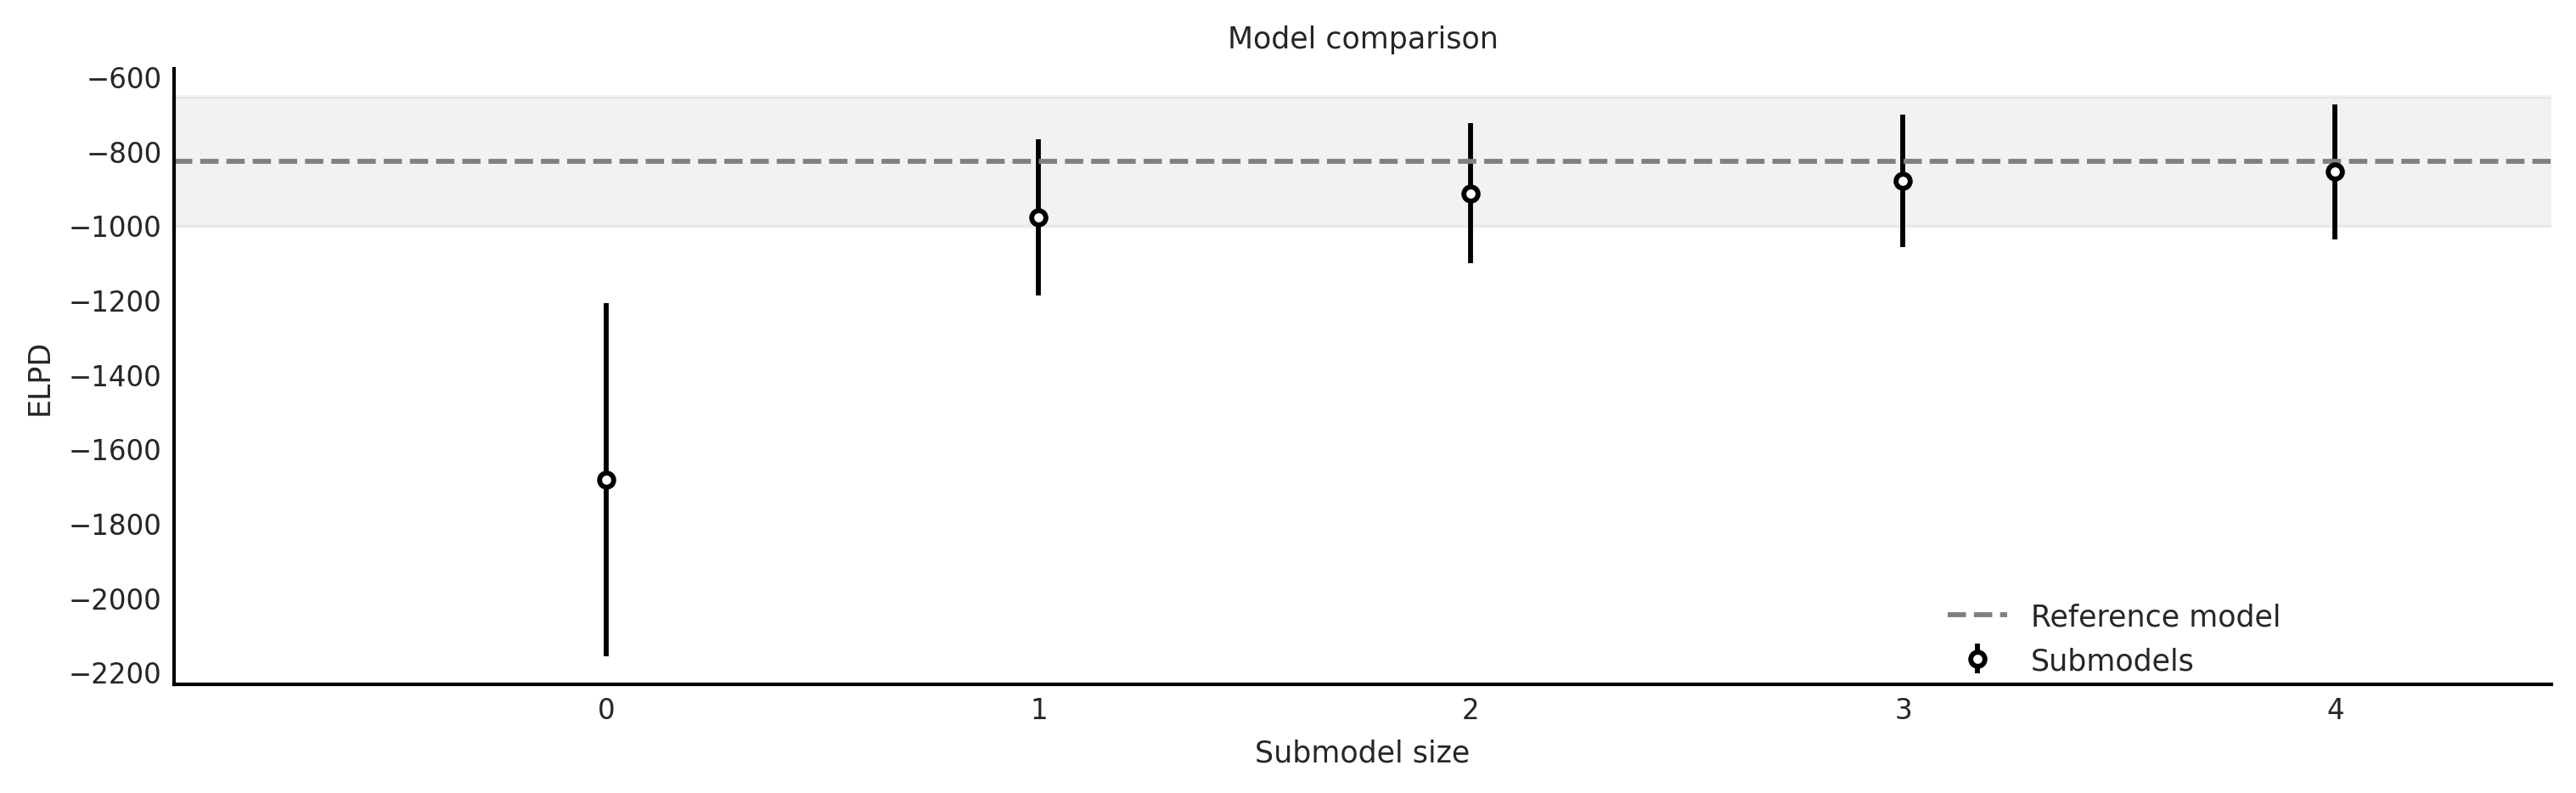

In [9]:
cmp, ax = ref_model.plot_compare(plot=True, figsize=(10, 3));